# Comprehensive Analysis of Salary Data

This notebook provides a step-by-step analysis of the salary dataset, including exploratory data analysis, visualization, outlier detection, and machine learning models.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import os

# Create images directory if it doesn't exist
os.makedirs('images', exist_ok=True)

# Set plot style
# plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')

## 1. Data Loading and Preparation

In [2]:
# Load data
df = pd.read_csv('data/salaries.csv')

# Display the first few rows
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,MI,FT,Customer Success Manager,57000,EUR,60000,NL,50,NL,L
1,2025,SE,FT,Engineer,165000,USD,165000,US,0,US,M
2,2025,SE,FT,Engineer,109000,USD,109000,US,0,US,M
3,2025,SE,FT,Applied Scientist,294000,USD,294000,US,0,US,M
4,2025,SE,FT,Applied Scientist,137600,USD,137600,US,0,US,M


In [3]:
# Display basic information
print("Dataset info:")
df.info()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88584 entries, 0 to 88583
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           88584 non-null  int64 
 1   experience_level    88584 non-null  object
 2   employment_type     88584 non-null  object
 3   job_title           88584 non-null  object
 4   salary              88584 non-null  int64 
 5   salary_currency     88584 non-null  object
 6   salary_in_usd       88584 non-null  int64 
 7   employee_residence  88584 non-null  object
 8   remote_ratio        88584 non-null  int64 
 9   company_location    88584 non-null  object
 10  company_size        88584 non-null  object
dtypes: int64(4), object(7)
memory usage: 7.4+ MB


In [4]:
# Display summary statistics
print("\nSummary statistics:")
df.describe()


Summary statistics:


,work_year,salary,salary_in_usd,remote_ratio
count,88584.000000,8.858400e+04,88584.000000,88584.000000
mean,2024.034758,1.619323e+05,157567.798417,21.286011
std,0.620370,1.965317e+05,73531.373158,40.831018
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2024.000000,1.060000e+05,106097.250000,0.000000
50%,2024.000000,1.470000e+05,146307.000000,0.000000
75%,2024.000000,1.995000e+05,198600.000000,0.000000
max,2025.000000,3.040000e+07,800000.000000,100.000000


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


In [6]:
# Convert categorical variables to more descriptive categories
experience_mapping = {
    'EN': 'Entry',
    'MI': 'Mid',
    'SE': 'Senior',
    'EX': 'Executive'
}

employment_mapping = {
    'FT': 'Full-time',
    'PT': 'Part-time',
    'CT': 'Contract'
}

company_size_mapping = {
    'S': 'Small',
    'M': 'Medium',
    'L': 'Large'
}

# Apply mappings
df['experience_level'] = df['experience_level'].map(experience_mapping)
df['employment_type'] = df['employment_type'].map(employment_mapping)
df['company_size'] = df['company_size'].map(company_size_mapping)

# Convert remote_ratio to categorical for better visualization
df['remote_ratio_category'] = pd.cut(
    df['remote_ratio'], 
    bins=[-1, 0, 50, 100], 
    labels=['On-site', 'Hybrid', 'Remote']
)

# Create income categories (low, middle, high) using quantiles
income_quantiles = df['salary_in_usd'].quantile([0, 1/3, 2/3, 1]).values
df['income_category'] = pd.cut(
    df['salary_in_usd'], 
    bins=income_quantiles, 
    labels=['Low', 'Middle', 'High'],
    include_lowest=True
)

# Print the income category thresholds
print("Income category thresholds:")
for i, threshold in enumerate(income_quantiles):
    if i == 0:
        print(f"Minimum: ${threshold:,.0f}")
    elif i == len(income_quantiles) - 1:
        print(f"Maximum: ${threshold:,.0f}")
    else:
        print(f"Threshold {i}: ${threshold:,.0f}")

Income category thresholds:
Minimum: $15,000
Threshold 1: $120,000
Threshold 2: $177,100
Maximum: $800,000


## 2. Exploratory Data Analysis

In [7]:
# Basic statistics of salary
salary_stats = df['salary_in_usd'].describe()
print("Salary statistics (USD):")
print(salary_stats)

Salary statistics (USD):
count     88584.000000
mean     157567.798417
std       73531.373158
min       15000.000000
25%      106097.250000
50%      146307.000000
75%      198600.000000
max      800000.000000
Name: salary_in_usd, dtype: float64


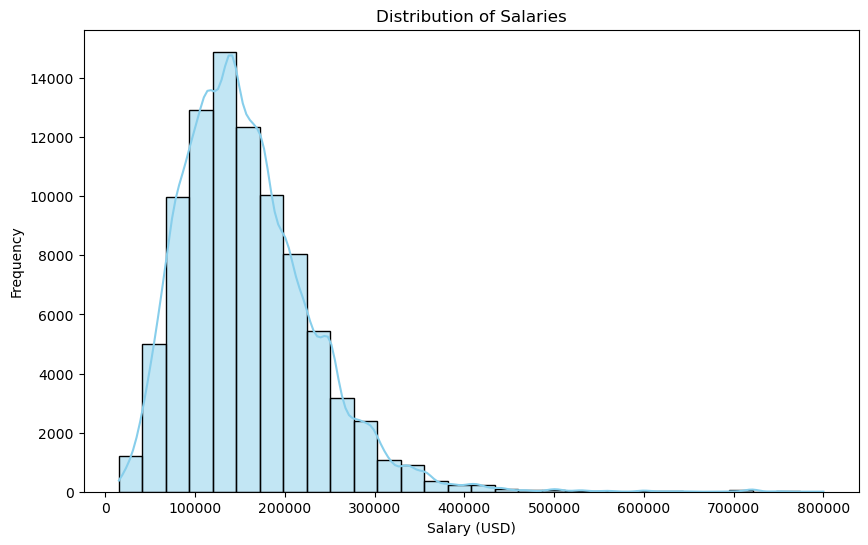

In [8]:
# Histogram of salaries
plt.figure(figsize=(10, 6))
sns.histplot(df['salary_in_usd'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Salaries')
plt.xlabel('Salary (USD)')
plt.ylabel('Frequency')
plt.savefig('images/salary_distribution.png')
plt.show()

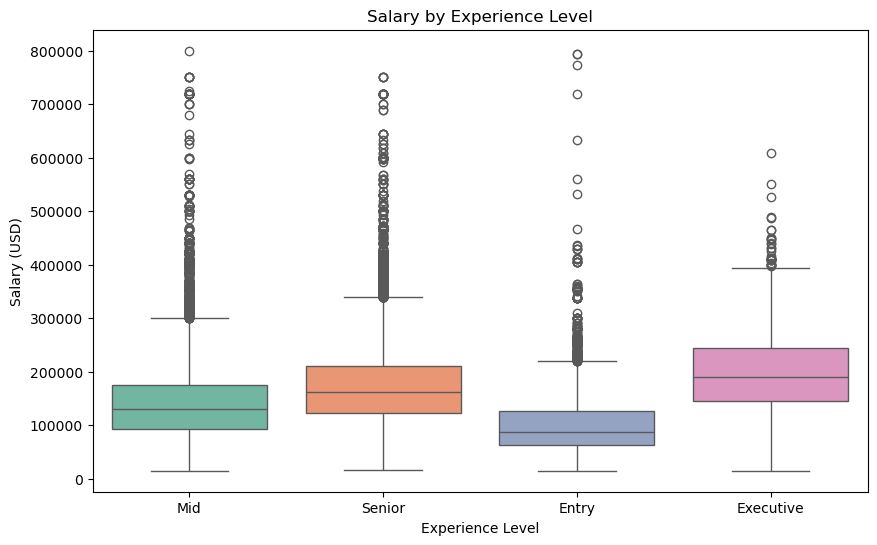

In [26]:
# Boxplot of salaries by experience level
plt.figure(figsize=(10, 6))
sns.boxplot(x='experience_level', y='salary_in_usd', hue='experience_level', data=df, palette='Set2', legend=False)
plt.title('Salary by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Salary (USD)')
plt.savefig('images/salary_by_experience.png')
plt.show()


/tmp/ipykernel_54697/3866111985.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='remote_ratio_category', y='salary_in_usd', data=df, palette='Set3')


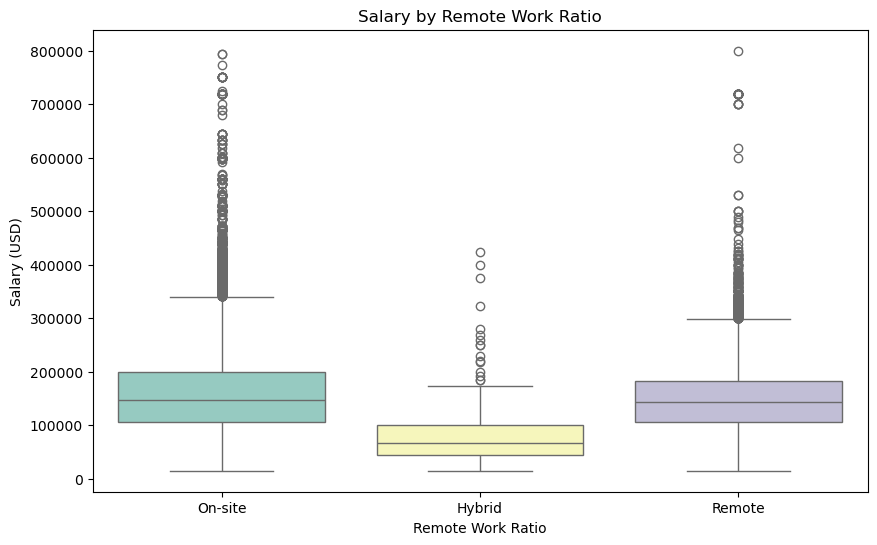

In [10]:
# Boxplot of salaries by remote work ratio
plt.figure(figsize=(10, 6))
sns.boxplot(x='remote_ratio_category', y='salary_in_usd', data=df, palette='Set3')
plt.title('Salary by Remote Work Ratio')
plt.xlabel('Remote Work Ratio')
plt.ylabel('Salary (USD)')
plt.savefig('images/salary_by_remote_ratio.png')
plt.show()

/tmp/ipykernel_54697/149975973.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='company_size', y='salary_in_usd', data=df, palette='Set1')


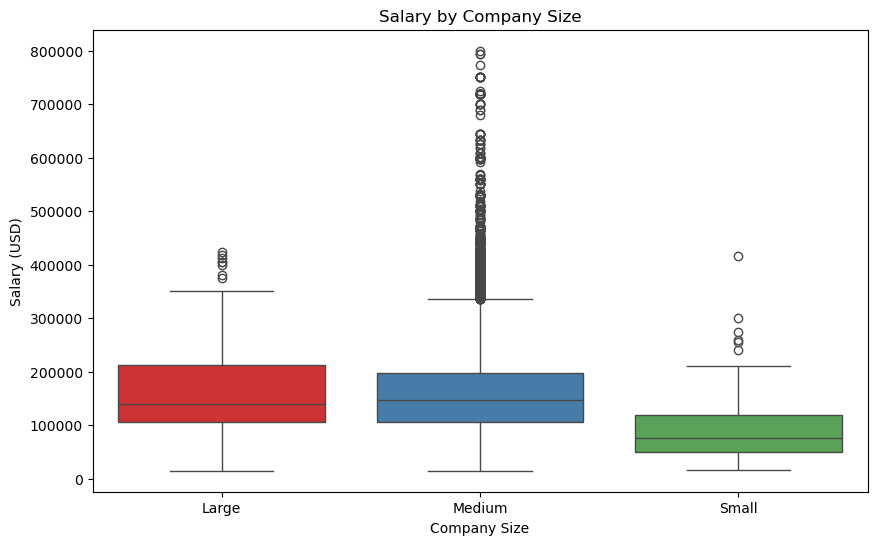

In [11]:
# Boxplot of salaries by company size
plt.figure(figsize=(10, 6))
sns.boxplot(x='company_size', y='salary_in_usd', data=df, palette='Set1')
plt.title('Salary by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Salary (USD)')
plt.savefig('images/salary_by_company_size.png')
plt.show()

/tmp/ipykernel_54697/151675487.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='salary_in_usd', y='job_title', data=job_avg, palette='viridis')


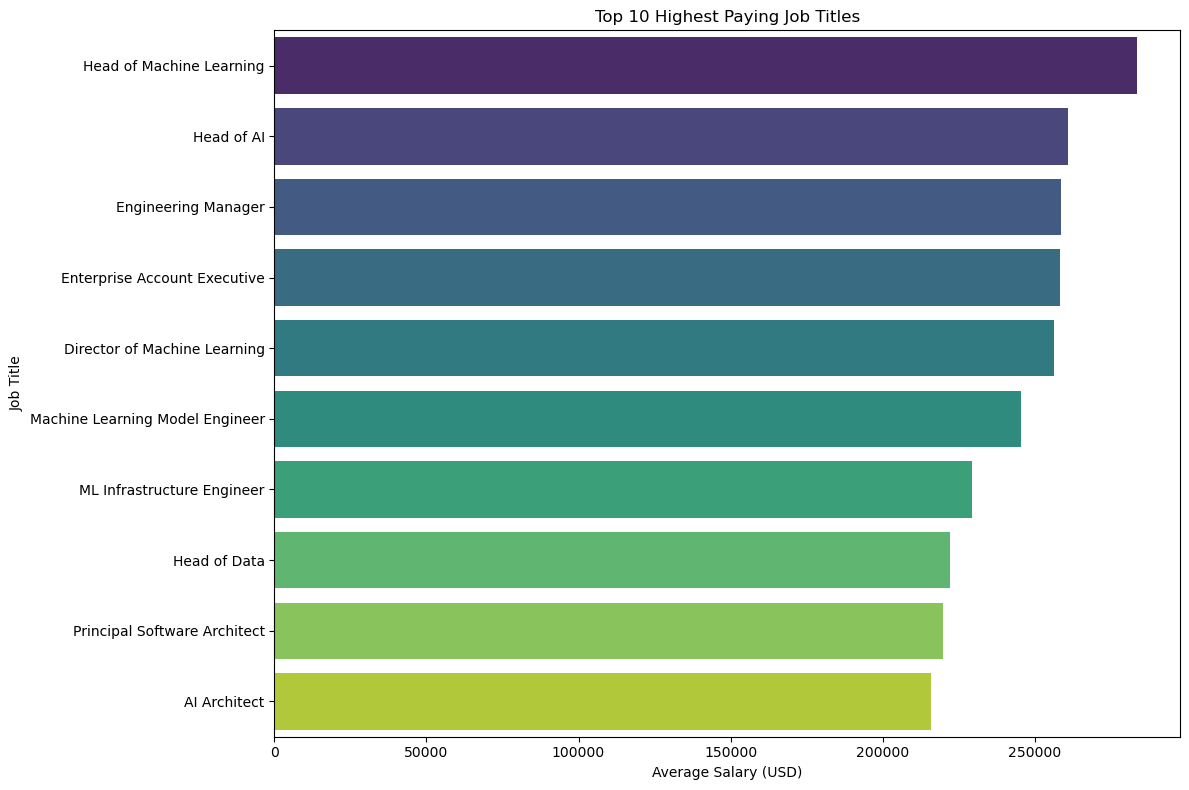

In [12]:
# Top 10 job titles by average salary
job_avg = df.groupby('job_title').agg({
    'salary_in_usd': 'mean',
    'job_title': 'count'
}).rename(columns={'job_title': 'count'}).reset_index()

# Only include job titles with at least 5 entries
job_avg = job_avg[job_avg['count'] >= 5].sort_values('salary_in_usd', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='salary_in_usd', y='job_title', data=job_avg, palette='viridis')
plt.title('Top 10 Highest Paying Job Titles')
plt.xlabel('Average Salary (USD)')
plt.ylabel('Job Title')
plt.tight_layout()
plt.savefig('images/top_10_job_titles.png')
plt.show()

/tmp/ipykernel_54697/632418932.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='income_category', data=df, palette='Blues')


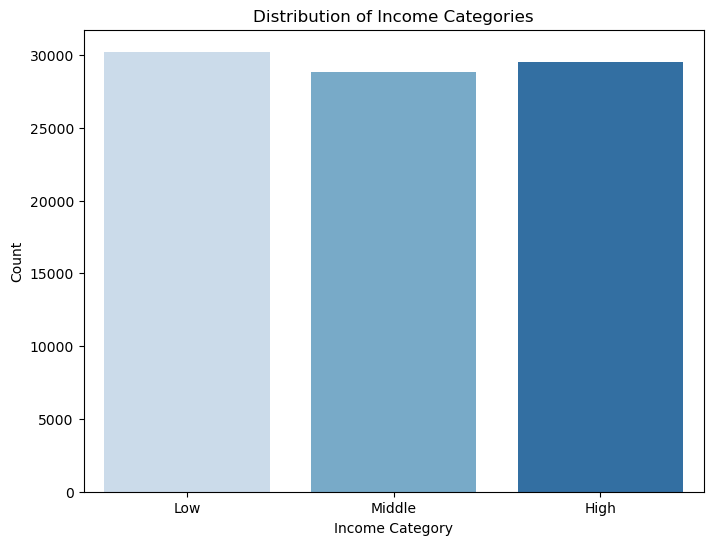

In [13]:
# Distribution of income categories
plt.figure(figsize=(8, 6))
sns.countplot(x='income_category', data=df, palette='Blues')
plt.title('Distribution of Income Categories')
plt.xlabel('Income Category')
plt.ylabel('Count')
plt.savefig('images/income_categories.png')
plt.show()

## 3. Outlier Detection

In [14]:
# Function to detect outliers using IQR method
def detect_outliers(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = (x < lower_bound) | (x > upper_bound)
    return {
        'outliers': outliers,
        'count': np.sum(outliers),
        'percentage': np.mean(outliers) * 100,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

# Detect outliers in salary_in_usd
salary_outliers = detect_outliers(df['salary_in_usd'])

print("Salary outliers:")
print(f"Count: {salary_outliers['count']}")
print(f"Percentage: {salary_outliers['percentage']:.2f}%")
print(f"Lower bound: {salary_outliers['lower_bound']}")
print(f"Upper bound: {salary_outliers['upper_bound']}")

Salary outliers:
Count: 1750
Percentage: 1.98%
Lower bound: -32656.875
Upper bound: 337354.125


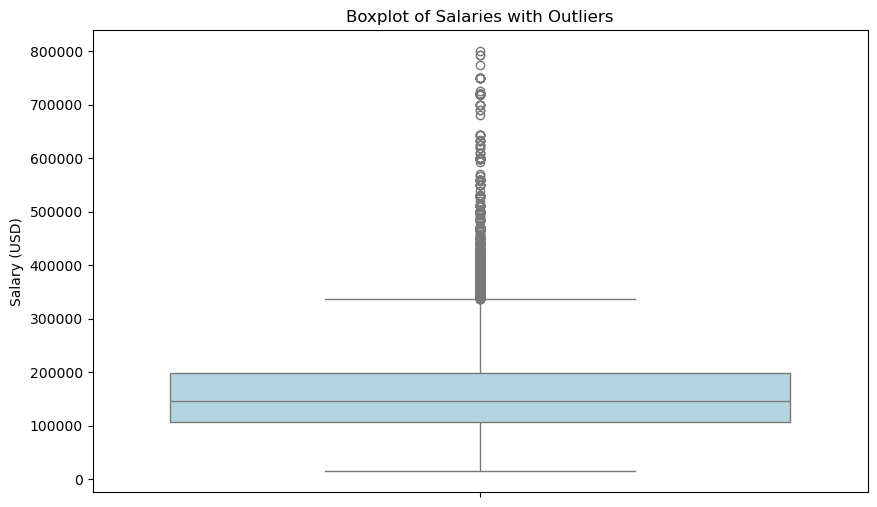

In [15]:
# Visualize outliers with a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['salary_in_usd'], color='lightblue')
plt.title('Boxplot of Salaries with Outliers')
plt.ylabel('Salary (USD)')
plt.savefig('images/salary_outliers_boxplot.png')
plt.show()

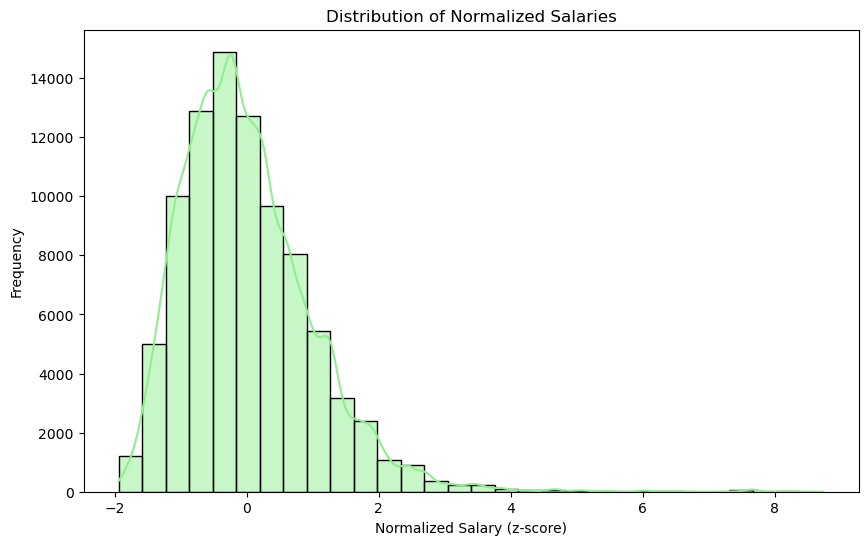

In [16]:
# Create normalized version of salary for better visualization
df['salary_normalized'] = StandardScaler().fit_transform(df[['salary_in_usd']])

# Histogram of normalized salaries
plt.figure(figsize=(10, 6))
sns.histplot(df['salary_normalized'], bins=30, kde=True, color='lightgreen')
plt.title('Distribution of Normalized Salaries')
plt.xlabel('Normalized Salary (z-score)')
plt.ylabel('Frequency')
plt.savefig('images/normalized_salary_distribution.png')
plt.show()

## 4. Correlation Analysis

Correlation matrix:
               salary_in_usd  remote_ratio  work_year
salary_in_usd       1.000000     -0.064520   0.031409
remote_ratio       -0.064520      1.000000  -0.120347
work_year           0.031409     -0.120347   1.000000


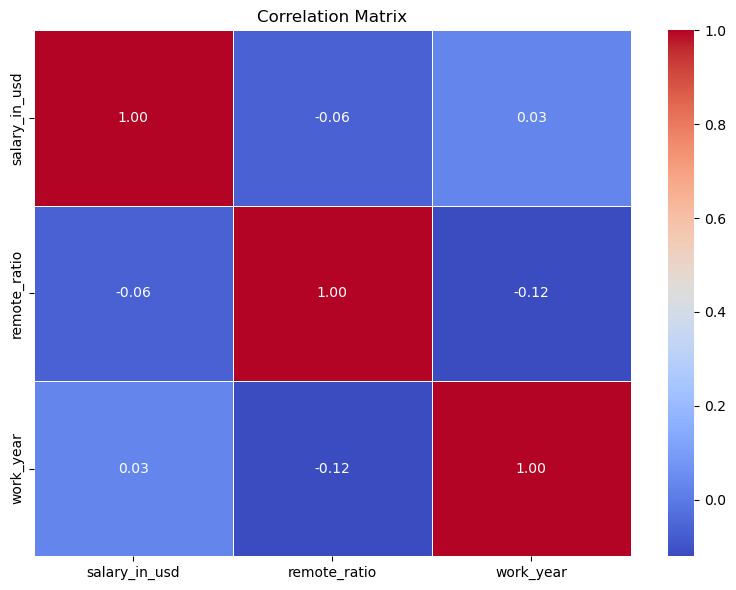

In [17]:
# Select numeric variables for correlation analysis
numeric_vars = df[['salary_in_usd', 'remote_ratio', 'work_year']]

# Calculate correlation matrix
cor_matrix = numeric_vars.corr()
print("Correlation matrix:")
print(cor_matrix)

# Visualize correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('images/correlation_matrix.png')
plt.show()

## 5. Modeling

In [19]:
# Prepare data for modeling
# Convert categorical variables to dummy variables
model_data = pd.get_dummies(df[['salary_in_usd', 'experience_level', 'employment_type', 
                               'remote_ratio', 'company_size', 'work_year']], 
                           drop_first=True)

# Split features and target
X = model_data.drop('salary_in_usd', axis=1)
y = model_data['salary_in_usd']

# Split data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Check for missing values
print("Missing values in training data:")
print(X_train.isnull().sum())

# Remove rows with missing values if any
X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]

Missing values in training data:
remote_ratio                  0
work_year                     0
experience_level_Executive    0
experience_level_Mid          0
experience_level_Senior       0
employment_type_Full-time     0
employment_type_Part-time     0
company_size_Medium           0
company_size_Small            0
dtype: int64


### 5.1 Linear Regression Model

In [20]:
# Linear Regression Model
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)

# Model coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lm_model.coef_
})
print("Linear Regression Coefficients:")
print(coef_df.sort_values('Coefficient', ascending=False))

# Predict on test data
lm_predictions = lm_model.predict(X_test)

# Calculate RMSE for linear model
lm_rmse = np.sqrt(mean_squared_error(y_test, lm_predictions))
lm_r2 = r2_score(y_test, lm_predictions)
print(f"Linear Model RMSE: ${lm_rmse:.2f}")
print(f"Linear Model R²: {lm_r2:.4f}")

Linear Regression Coefficients:
                      Feature   Coefficient
2  experience_level_Executive  97291.045840
4     experience_level_Senior  73662.196440
3        experience_level_Mid  41377.586334
5   employment_type_Full-time  41138.584323
1                   work_year   4557.528337
6   employment_type_Part-time    507.654104
0                remote_ratio   -145.823205
7         company_size_Medium  -2836.113642
8          company_size_Small -38396.209520
Linear Model RMSE: $69685.85
Linear Model R²: 0.1090


### 5.2 Random Forest Model

Random Forest Model RMSE: $69428.20
Random Forest Model R²: 0.1155

Feature Importance:
                      Feature  Importance
4     experience_level_Senior    0.511916
3        experience_level_Mid    0.186331
2  experience_level_Executive    0.123517
0                remote_ratio    0.076232
1                   work_year    0.059575
7         company_size_Medium    0.015132
5   employment_type_Full-time    0.014278
8          company_size_Small    0.007769
6   employment_type_Part-time    0.005249


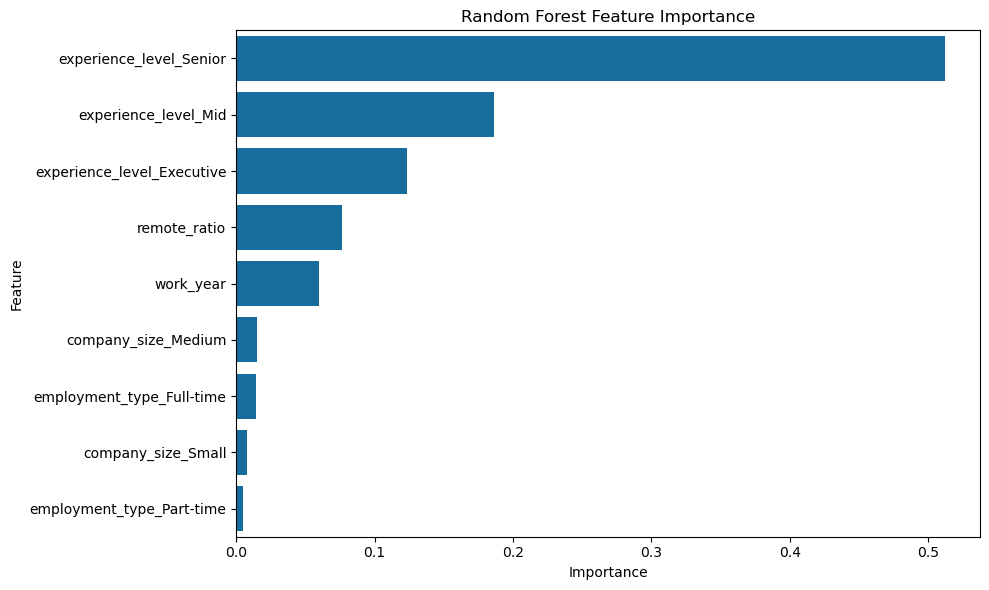

In [21]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=123)
rf_model.fit(X_train, y_train)

# Predict on test data
rf_predictions = rf_model.predict(X_test)

# Calculate RMSE for random forest model
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)
print(f"Random Forest Model RMSE: ${rf_rmse:.2f}")
print(f"Random Forest Model R²: {rf_r2:.4f}")

# Variable importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot variable importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.savefig('images/variable_importance.png')
plt.show()

### 5.3 Generalized Additive Model (GAM) Equivalent

Python doesn't have a direct equivalent to R's GAM, but we can use a combination of polynomial features and linear regression to approximate non-linear relationships.

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Create polynomial features for continuous variables (work_year and remote_ratio)
# First, extract these features
continuous_features = ['work_year', 'remote_ratio']
continuous_indices = [i for i, col in enumerate(X_train.columns) if any(feat in col for feat in continuous_features)]

# Create a polynomial model (degree=3 to approximate GAM's smoothing)
poly_model = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),
    LinearRegression()
)
poly_model.fit(X_train, y_train)

# Predict on test data
poly_predictions = poly_model.predict(X_test)

# Calculate RMSE for polynomial model
poly_rmse = np.sqrt(mean_squared_error(y_test, poly_predictions))
poly_r2 = r2_score(y_test, poly_predictions)
print(f"Polynomial Model RMSE: ${poly_rmse:.2f}")
print(f"Polynomial Model R²: {poly_r2:.4f}")

Polynomial Model RMSE: $69458.64
Polynomial Model R²: 0.1148


### 5.4 Multinomial Logistic Regression for Income Category

/home/obote/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/obote/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for Income Category Classification:
[[5444 2216 1242]
 [2736 5320 1011]
 [4132 3026 1449]]

Classification Report:
              precision    recall  f1-score   support

        High       0.44      0.61      0.51      8902
         Low       0.50      0.59      0.54      9067
      Middle       0.39      0.17      0.24      8607

    accuracy                           0.46     26576
   macro avg       0.45      0.46      0.43     26576
weighted avg       0.45      0.46      0.43     26576



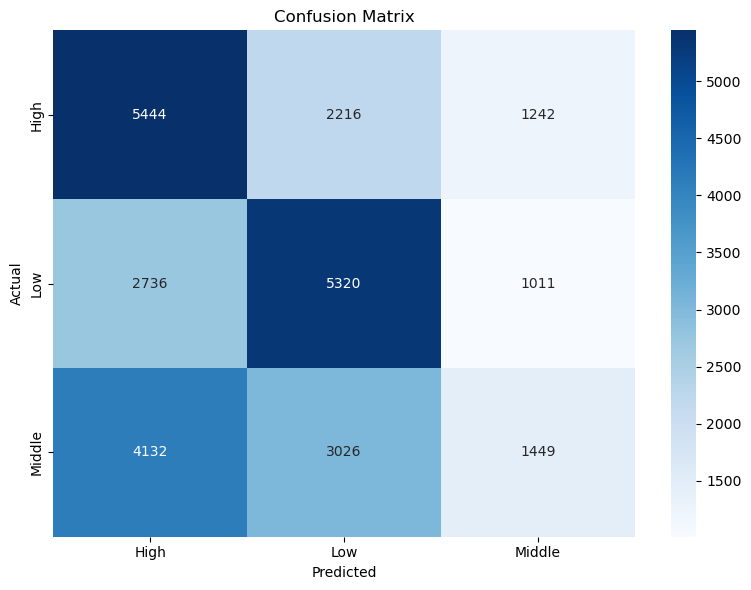

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Prepare data for classification
class_data = pd.get_dummies(df[['income_category', 'experience_level', 'employment_type', 
                              'remote_ratio', 'company_size', 'work_year']], 
                          drop_first=True)

# Split features and target
X_class = class_data.drop([col for col in class_data.columns if 'income_category' in col], axis=1)
y_class = df['income_category']

# Split data for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.3, random_state=123
)

# Remove rows with missing values if any
X_train_class = X_train_class.dropna()
y_train_class = y_train_class[X_train_class.index]
X_test_class = X_test_class.dropna()
y_test_class = y_test_class[X_test_class.index]

# Train multinomial model
multinom_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
multinom_model.fit(X_train_class, y_train_class)

# Predict on test data
multinom_predictions = multinom_model.predict(X_test_class)

# Confusion matrix
conf_mat = confusion_matrix(y_test_class, multinom_predictions)
print("Confusion Matrix for Income Category Classification:")
print(conf_mat)

# Classification report
class_report = classification_report(y_test_class, multinom_predictions)
print("\nClassification Report:")
print(class_report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=multinom_model.classes_, 
            yticklabels=multinom_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('images/confusion_matrix.png')
plt.show()

## 6. Model Comparison and Evaluation

Model Comparison:
                   Model          RMSE        R²
0      Linear Regression  69685.849053  0.108973
1          Random Forest  69428.199739  0.115550
2  Polynomial Regression  69458.638578  0.114774


/tmp/ipykernel_54697/3618050783.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=model_comparison, palette='viridis')


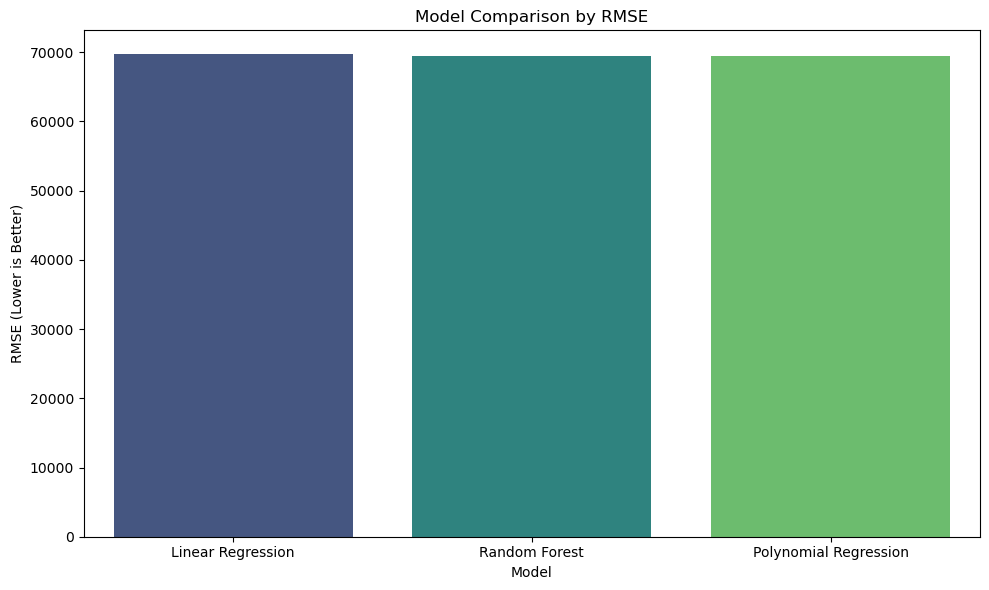

In [24]:
# Compare RMSE of different regression models
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Polynomial Regression'],
    'RMSE': [lm_rmse, rf_rmse, poly_rmse],
    'R²': [lm_r2, rf_r2, poly_r2]
})

print("Model Comparison:")
print(model_comparison)

# Plot model comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=model_comparison, palette='viridis')
plt.title('Model Comparison by RMSE')
plt.ylabel('RMSE (Lower is Better)')
plt.tight_layout()
plt.savefig('images/model_comparison.png')
plt.show()

## 7. Conclusion

In [25]:
print("=== ANALYSIS SUMMARY ===")
print(f"Dataset contains {len(df)} salary records")
print(f"Salary range: ${df['salary_in_usd'].min():,} to ${df['salary_in_usd'].max():,}")
print(f"Income categories: Low (<${income_quantiles[1]:,.0f}), "
      f"Middle (${income_quantiles[1]:,.0f}-${income_quantiles[2]:,.0f}), "
      f"High (>${income_quantiles[2]:,.0f})")
print(f"Best performing model: {model_comparison.loc[model_comparison['RMSE'].idxmin(), 'Model']} "
      f"(RMSE = ${model_comparison['RMSE'].min():.2f})")
print(f"Outliers detected: {salary_outliers['count']} ({salary_outliers['percentage']:.2f}%)")
print(f"Most important salary predictor: {feature_importance.iloc[0]['Feature']}")
print(f"Classification accuracy: {accuracy_score(y_test_class, multinom_predictions) * 100:.2f}%")

=== ANALYSIS SUMMARY ===
Dataset contains 88584 salary records
Salary range: $15,000 to $800,000
Income categories: Low (<$120,000), Middle ($120,000-$177,100), High (>$177,100)
Best performing model: Random Forest (RMSE = $69428.20)
Outliers detected: 1750 (1.98%)
Most important salary predictor: experience_level_Senior
Classification accuracy: 45.95%
